In [4]:
# PageRank 应用
import networkx as nx

# 创建有向图
G = nx.DiGraph()

# 有向图之间边的关系
edges = [("A", "B"), ("A", "C"), ("A", "D"), ("B", "A"), ("B", "D"), ("C", "A"), ("D", "B"), ("D", "C")]
for edge in edges:
    G.add_edge(edge[0],edge[1])
pagerank_list = nx.pagerank(G, alpha=1)
print(f'pagerank值是:{pagerank_list}')



pagerank值是:{'A': 0.33333396911621094, 'B': 0.22222201029459634, 'C': 0.22222201029459634, 'D': 0.22222201029459634}


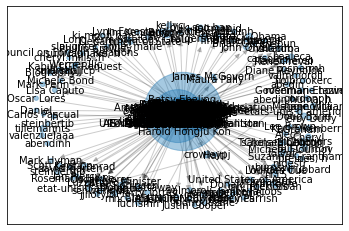

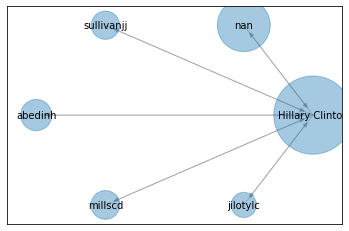

In [28]:
# 希拉里邮件中的人物关系
'''
数据由三个文件组成，Aliases.csv、Emails.csv和Persons.csv
Emails记录了所有公开邮件的内容、发送者和接受者的信息
Persons统计了邮件中所有人物的姓名及对应的ID
姓名存在别名，为了将人物进行统一，我们还需要Aliases查询别名和人物的对应关系
'''

import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# 加载数据
emails = pd.read_csv('data/PageRank/Emails.csv')

#读取别名文件
file = pd.read_csv('data/PageRank/Aliases.csv')
aliases = {}
for index, row in file.iterrows():
    aliases[row['Alias']] = row['PersonId']

# 读取人名文件
file = pd.read_csv('data/PageRank/Persons.csv')

persons = {}
for index, row in file.iterrows():
    persons[row['Id']] = row['Name']

# 针对别名进行转换
def unify_name(name):
    # 姓名统一小写
    name = str(name).lower()
    # 去掉,和@后面的内容
    name = name.replace(',','').split('@')[0]
    # 别名转换
    if name in aliases.keys():
        return persons[aliases[name]]
    return name

# 画网络图
def show_graph(graph, layout='spring_layout'):
    # 使用 Spring layout布局，类似中心放射状
    if layout == 'circular_layout':
        positions = nx.circular_layout(graph)
    else:
        positions = nx.spring_layout(graph)

    # 设置网络图中的节点大小，大小与PageRank值相关，因为pagerank值很小所以需要*20000
    nodesize = [x['pagerank']*20000 for v,x in graph.nodes(data=True)]

    # 设置网络图中的长度
    edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data=True)]

    # 绘制节点
    nx.draw_networkx_nodes(graph,positions,node_size=nodesize, alpha=0.4)
    
    # 绘制边
    nx.draw_networkx_edges(graph,positions,edge_size=edgesize, alpha=0.2)
    
    # 绘制节点label
    nx.draw_networkx_labels(graph, positions, font_size=10)
    
    
    # 输出希拉里邮件中的所有人物关系图
    plt.show()
    
# 将寄件人和收件人的姓名进行规范
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

# 设置边的权重等于发邮件的次数
edges_weights_temp = defaultdict(list)
for row in zip(emails.MetadataFrom, emails.MetadataTo, emails.RawText):
    temp = (row[0], row[1])
    if temp not in edges_weights_temp:
        edges_weights_temp[temp] = 1
    else:
        edges_weights_temp[temp]  = edges_weights_temp[temp] +1

# 转化格式(from, to), weight => from, to, weight
edges_weights = [(key[0], key[1], val) for key, val in edges_weights_temp.items()]

# 创建一个有向图
graph = nx.DiGraph()

# 设置有向图中的路径及权重(from, to, weight)
graph.add_weighted_edges_from(edges_weights)

# 计算每个节点(人)的PR值，作为节点的Pagerank属性
pagerank = nx.pagerank(graph)

# 将pagerank数值作为节点的属性
nx.set_node_attributes(graph, name='pagerank', values=pagerank)

# 画网络图
show_graph(graph)

# 将完整的图谱ijnxing精简
#设置PR值的阈值，筛选大于阈值的重要核心节点
pagerank_threshold = 0.02
# 复制一份计算好的网络图
small_graph = graph.copy()

# 减掉PR值小于pagerank_threshold的节点
for n,p_rank in graph.nodes(data=True):
    if p_rank['pagerank'] < pagerank_threshold:
        small_graph.remove_node(n)

# 画网络图，采用circular_layout布局让筛选出来的点组成一个圆
show_graph(small_graph, 'circular_layout')